## GPR with New kernels

After debugging the `GPJax` kernels to match the `PyTorch` kernels, this notebook will re-implement GPR.

In [1]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_data import JAXP53_Data, dataset_3d, generate_test_times
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
p53_data = JAXP53_Data(replicate=0)
training_times, gene_expressions, variances = dataset_3d(p53_data)

In [3]:
@dataclass
class latent_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = "p53 Cov"

    # Define parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    # Redefine parameters as static fields
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))
    #l: Float[Array, " O"] = static_field(jnp.array(2.5))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t, t_prime).T
        )

        return final_kernel
    
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.l.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        # Debug print
        """
        print(f"j: {j}")
        print(f"k: {k}")
        print(f"t1: {t1}")
        print(f"t2: {t2}")
        """
        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2

## GPR

Using zero mean for now.

In [4]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior, history

In [5]:
dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

In [6]:
mean = gpx.mean_functions.Zero()
kernel = latent_kernel()

# Define the model
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel, jitter=1e-4)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=dataset_train.n)
posterior = prior * likelihood

In [7]:
optimised_posterior, history = optimise_mll(posterior, dataset_train)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


MLL before opt: 44.145
Optimization terminated successfully.
         Current function value: 8.756255
         Iterations: 38
         Function evaluations: 44
         Gradient evaluations: 44


In [9]:
latent_dist = optimised_posterior.predict(testing_times, train_data=dataset_train)
predictive_dist = optimised_posterior.likelihood(latent_dist)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [10]:
print(latent_dist.stddev())
print(predictive_dist.stddev())

[0.5516667  0.44035638 0.33760997 0.26101191 0.22481172 0.22088422
 0.22308995 0.21387686 0.19250786 0.17298358 0.17546265 0.20288686
 0.2373705  0.26198998 0.26912458 0.25931073 0.23849422 0.21425594
 0.19169604 0.17206537 0.15672855 0.15243222 0.1672968  0.19830467
 0.23252782 0.25774245 0.26723376 0.2604293  0.2417597  0.21795779
 0.19446189 0.1735073  0.15680177 0.15054425 0.16308185 0.19285293
 0.22760786 0.25476355 0.26682295 0.26235035 0.24512278 0.22171078
 0.19793976 0.1764994  0.15885257 0.15036371 0.15978391 0.18763325
 0.22260678 0.25160567 0.26620346 0.26406774 0.24837118 0.22559144
 0.20193688 0.18040283 0.16196691 0.15101996 0.15698958 0.18317671
 0.21925535 0.25086868 0.26791632 0.26697443 0.25158428 0.23067328
 0.2136476  0.2030056  0.19253654 0.17630432 0.16236237 0.18046797
 0.2501731  0.35549361 0.47503954 0.59363643 0.7011199  0.79146364
 0.86228252 0.91413795]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [12]:
def plot_gp(x_test, predictive_dist):
    """
    Plot LF GP given test points and prediction

    Parameters
    ----------
    x_test: array of shape (n, 3)
    predictive_dist:  jax mvn
    """

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    # (100,)
    x_test = x_test[:,0]

    import matplotlib as mpl
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    
    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")

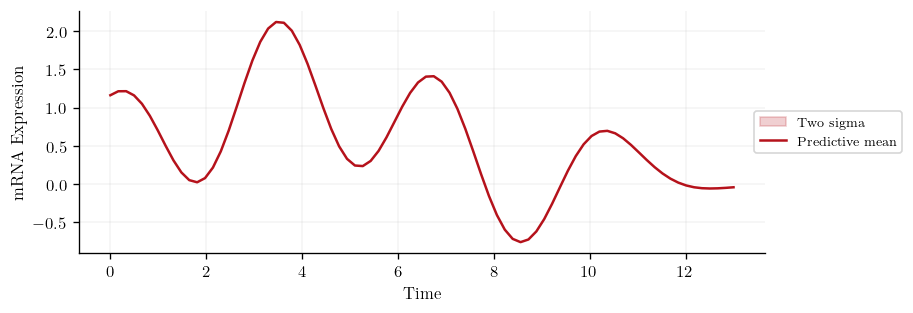

In [14]:
plot_gp(testing_times, predictive_dist)

### GPR with custom predict method

In [16]:
import cola
from gpjax.dataset import Dataset
from gpjax.distributions import GaussianDistribution
from jaxtyping import Num

class opt_p53_posterior(gpx.gps.ConjugatePosterior):

    def custom_predict(self, test_inputs: Num[Array, "N D"], train_data: Dataset) -> GaussianDistribution:

        jitter = 1e-3
        
        x, y = train_data.X, train_data.y
        t = test_inputs

        diag_variances = jnp.diag(variances.reshape(-1))
         
        Kxx = self.prior.kernel.gram(x)
        Kxx += diag_variances
        Kxx += cola.ops.I_like(Kxx) * self.prior.jitter # + 1e-4
        #Kxx += cola.ops.I_like(Kxx) * jitter
        K_inv = cola.inv(Kxx)

        Kxf = self.prior.kernel.cross_covariance(x, t)
        KfxKxx = jnp.matmul(Kxf.T, K_inv.to_dense())
        mean = jnp.matmul(KfxKxx, y)

        Kff = self.prior.kernel.gram(t)
        Kff += cola.ops.I_like(Kff) * jitter # + 1e-3

        var = Kff - jnp.matmul(KfxKxx, Kxf)
        var = jnp.diag(jnp.diag(var.to_dense()))
        var += cola.ops.I_like(var) * jitter

         
        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)

In [19]:
custom_posterior = opt_p53_posterior(prior=optimised_posterior.prior, likelihood=optimised_posterior.likelihood)

latent_custom = custom_posterior.custom_predict(testing_times, dataset_train)

In [20]:
latent_custom.stddev()

Array([0.5867823 , 0.48013037, 0.37900797, 0.29888029, 0.25386596,
       0.24209733, 0.24294986, 0.23770398, 0.22242908, 0.20899632,
       0.21826888, 0.25787354, 0.31275149, 0.36304398, 0.39470852,
       0.40045208, 0.37917424, 0.33577007, 0.28187895, 0.23796528,
       0.22973797, 0.26356763, 0.3180624 , 0.37092937, 0.40932746,
       0.42756262, 0.42485043, 0.40392149, 0.36974794, 0.32832948,
       0.2860623 , 0.25031741, 0.23042985, 0.23477593, 0.26271972,
       0.30359413, 0.34449526, 0.37537524, 0.39021766, 0.38693474,
       0.36674524, 0.333265  , 0.29186564, 0.2500905 , 0.21909005,
       0.21186784, 0.23211177, 0.26813405, 0.30403242, 0.32843672,
       0.33596138, 0.32666615, 0.30473849, 0.27616707, 0.24592509,
       0.21657115, 0.19037742, 0.17398912, 0.17811382, 0.20498542,
       0.24252273, 0.27565564, 0.29434106, 0.29528531, 0.28164778,
       0.2610871 , 0.24138601, 0.22501415, 0.20819836, 0.18818535,
       0.17536068, 0.19764485, 0.26918751, 0.37374663, 0.49125

In [21]:
predictive_dist_custom = optimised_posterior.likelihood(latent_custom)

In [22]:
predictive_dist_custom.stddev()

Array([0.61065627, 0.50903123, 0.41501164, 0.34339051, 0.30501728,
       0.29529432, 0.29599366, 0.29170327, 0.27939634, 0.26882536,
       0.27609585, 0.30836079, 0.35552934, 0.40048539, 0.42939776,
       0.4346832 , 0.41516349, 0.3759377 , 0.32869949, 0.29191624,
       0.28524928, 0.31313816, 0.36021009, 0.40764717, 0.4428731 ,
       0.45977974, 0.45725868, 0.43788147, 0.40657245, 0.36930728,
       0.33229393, 0.30207023, 0.2858068 , 0.28932223, 0.31242482,
       0.34750109, 0.3837507 , 0.41169672, 0.42527337, 0.42226308,
       0.40384364, 0.37370199, 0.33730278, 0.30188222, 0.27674549,
       0.27106382, 0.28716457, 0.3169913 , 0.34788407, 0.36940262,
       0.37610858, 0.36782929, 0.34850131, 0.32381455, 0.29844055,
       0.27475567, 0.25461967, 0.24261045, 0.24558532, 0.2657191 ,
       0.29564318, 0.32337848, 0.33944701, 0.34026611, 0.32850128,
       0.3110532 , 0.29471142, 0.28145867, 0.26820546, 0.25298487,
       0.24359594, 0.26009826, 0.31788289, 0.41021233, 0.51953

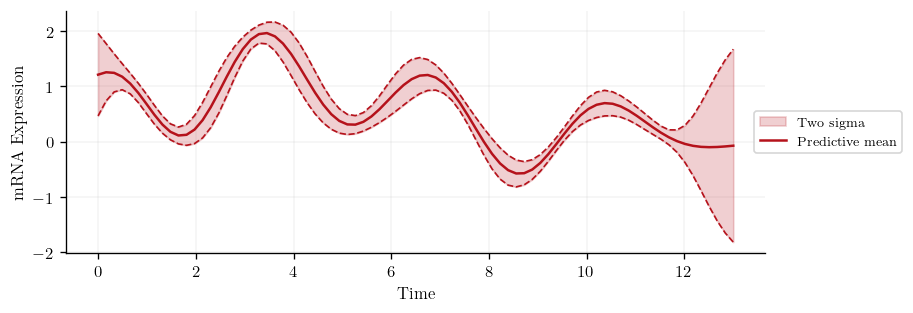

In [23]:
plot_gp(testing_times, predictive_dist_custom)